<!--TITLE: Maximum Pooling-->
# Introduction #

In Lesson 2 we began our discussion of how the base in a convnet performs feature extraction. We learned about how the first two operations in this process occur in a `Conv2D` layer with `relu` activation.

In this lesson, we'll look at the third (and final) operation in this sequence: **condense** with **maximum pooling**, which in Keras is done by a `MaxPool2D` layer.

# Condense with Maximum Pooling #

Adding condensing step to the model we had before, will give us this:

In [1]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Conv2D(filters=64, kernel_size=3), # activation is None
    layers.MaxPool2D(pool_size=2),
    # More layers follow
])

A `MaxPool2D` layer is much like a `Conv2D` layer, except that it uses a simple maximum function instead of a kernel, with the `pool_size` parameter analogous to `kernel_size`. A `MaxPool2D` layer doesn't have any trainable weights like a convolutional layer does in its kernel, however.

Let's take another look at the extraction figure from the last lesson. Remember that `MaxPool2D` is the **Condense** step.

<figure>
<!-- <img src="./images/2-show-extraction.png" width="1200" alt="An example of the feature extraction process."> -->
<img src="https://storage.googleapis.com/kaggle-media/learn/images/IYO9lqp.png" width="600" alt="An example of the feature extraction process.">
</figure>

Notice that after applying the ReLU function (**Detect**) the feature map ends up with a lot of "dead space," that is, large areas containing only 0's (the black areas in the image). Having to carry these 0 activations through the entire network would increase the size of the model without adding much useful information. Instead, we would like to *condense* the feature map to retain only the most useful part -- the feature itself.

This in fact is what **maximum pooling** does. Max pooling takes a patch of activations in the original feature map and replaces them with the maximum activation in that patch.

<figure>
<!-- <img src="./images/3-max-pooling.png" width="600" alt="Maximum pooling replaces a patch with the maximum value in that patch."> -->
<img src="https://storage.googleapis.com/kaggle-media/learn/images/hK5U2cd.png" width="400" alt="Maximum pooling replaces a patch with the maximum value in that patch.">
</figure>

When applied after the ReLU activation, it has the effect of "intensifying" features. The pooling step increases the proportion of active pixels to zero pixels.

# Example - Apply Maximum Pooling #

Let's add the "condense" step to the feature extraction we did in the example in Lesson 2. This next hidden cell will take us back to where we left off.

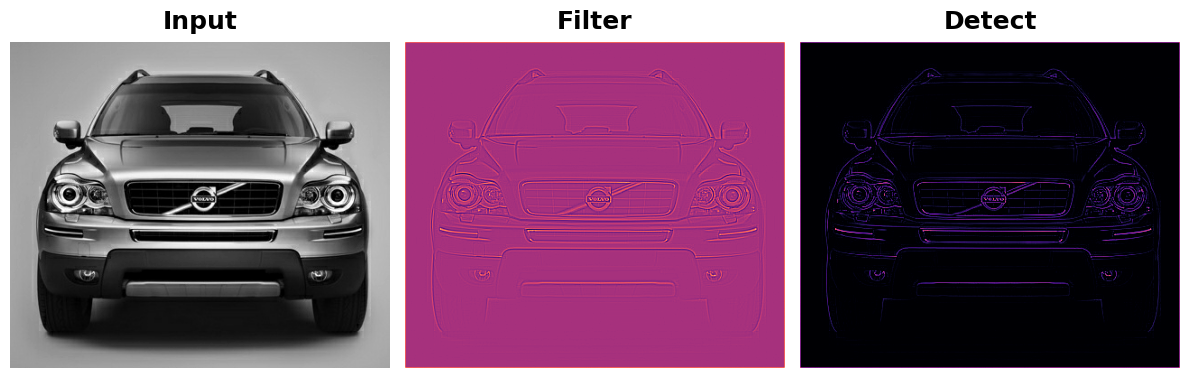

In [2]:

import tensorflow as tf
import matplotlib.pyplot as plt
import warnings

plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings("ignore") # to clean up output cells

# Read image
image_path = '../input/computer-vision-resources/car_feature.jpg'
image = tf.io.read_file(image_path)
image = tf.io.decode_jpeg(image)

# Define kernel
kernel = tf.constant([
    [-1, -1, -1],
    [-1,  8, -1],
    [-1, -1, -1],
], dtype=tf.float32)

# Reformat for batch compatibility.
image = tf.image.convert_image_dtype(image, dtype=tf.float32)
image = tf.expand_dims(image, axis=0)
kernel = tf.reshape(kernel, [*kernel.shape, 1, 1])

# Filter step
image_filter = tf.nn.conv2d(
    input=image,
    filters=kernel,
    # we'll talk about these two in the next lesson!
    strides=1,
    padding='SAME'
)

# Detect step
image_detect = tf.nn.relu(image_filter)

# Show what we have so far
plt.figure(figsize=(12, 6))
plt.subplot(131)
plt.imshow(tf.squeeze(image), cmap='gray')
plt.axis('off')
plt.title('Input')
plt.subplot(132)
plt.imshow(tf.squeeze(image_filter))
plt.axis('off')
plt.title('Filter')
plt.subplot(133)
plt.imshow(tf.squeeze(image_detect))
plt.axis('off')
plt.title('Detect')
plt.show();

We'll use another one of the functions in `tf.nn` to apply the pooling step, `tf.nn.pool`. This is a Python function that does the same thing as the `MaxPool2D` layer you use when model building, but, being a simple function, is easier to use directly.

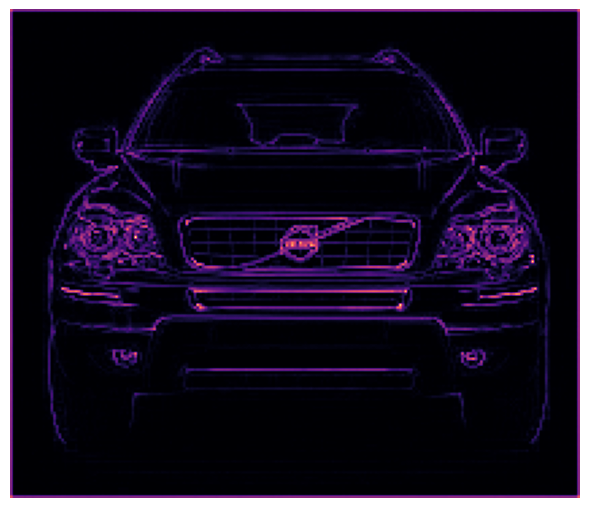

In [3]:
import tensorflow as tf

image_condense = tf.nn.pool(
    input=image_detect, # image in the Detect step above
    window_shape=(2, 2),
    pooling_type='MAX',
    # we'll see what these do in the next lesson!
    strides=(2, 2),
    padding='SAME',
)

plt.figure(figsize=(6, 6))
plt.imshow(tf.squeeze(image_condense))
plt.axis('off')
plt.show();

Pretty cool! Hopefully you can see how the pooling step was able to intensify the feature by condensing the image around the most active pixels.

# Translation Invariance #

We called the zero-pixels "unimportant". Does this mean they carry no information at all? In fact, the zero-pixels carry *positional information*. The blank space still positions the feature within the image. When `MaxPool2D` removes some of these pixels, it removes some of the positional information in the feature map. This gives a convnet a property called **translation invariance**. This means that a convnet with maximum pooling will tend not to distinguish features by their *location* in the image. ("Translation" is the mathematical word for changing the position of something without rotating it or changing its shape or size.)

Watch what happens when we repeatedly apply maximum pooling to the following feature map.

<figure>
<!-- <img src="./images/4-two-dots.png" width="800" alt="Pooling tends to destroy positional information."> -->
<img src="https://storage.googleapis.com/kaggle-media/learn/images/97j8WA1.png" width="800" alt="Pooling tends to destroy positional information.">
</figure>

The two dots in the original image became indistinguishable after repeated pooling. In other words, pooling destroyed some of their positional information. Since the network can no longer distinguish between them in the feature maps, it can't distinguish them in the original image either: it has become *invariant* to that difference in position.

In fact, pooling only creates translation invariance in a network *over small distances*, as with the two dots in the image. Features that begin far apart will remain distinct after pooling; only *some* of the positional information was lost, but not all of it.

<figure>
<!-- <img src="./images/4-two-dots-2.png" width="800" alt="Pooling tends to destroy positional information."> -->
<img src="https://storage.googleapis.com/kaggle-media/learn/images/kUMWdcP.png" width="800" alt="But only over small distances. Two dots far apart stay separated">
</figure>

This invariance to small differences in the positions of features is a nice property for an image classifier to have. Just because of differences in perspective or framing, the same kind of feature might be positioned in various parts of the original image, but we would still like for the classifier to recognize that they are the same. Because this invariance is *built into* the network, we can get away with using much less data for training: we no longer have to teach it to ignore that difference. This gives convolutional networks a big efficiency advantage over a network with only dense layers. (You'll see another way to get invariance for free in **Lesson 6** with **Data Augmentation**!)

# Conclusion #

In this lesson, we learned the about the last step of feature extraction: **condense** with `MaxPool2D`. In Lesson 4, we'll finish up our discussion of convolution and pooling with *sliding windows*.

# Your Turn #

Now, start the [**Exercise**](https://www.kaggle.com/kernels/fork/11989559) to finish the extraction you started in Lesson 2, see this invariance property in action, and also learn about another kind of pooling: **average pooling**!

---




*Have questions or comments? Visit the [course discussion forum](https://www.kaggle.com/learn/computer-vision/discussion) to chat with other learners.*